# Face Generation
Using generative adversarial networks (GAN) to generate new images of faces from celebrity images.

### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.76KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. We can view the first number of examples by changing `show_n_images`. 

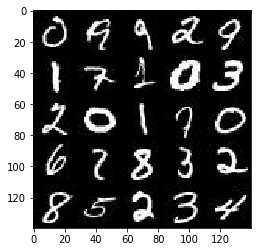

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  We can view the first number of examples by changing `show_n_images`.

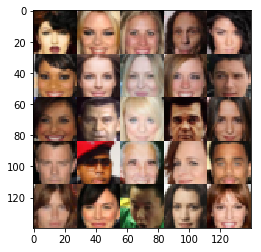

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs. The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network
We'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure we have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1_act = tf.maximum(x1 * 0.1, x1)
        # now 14x14x64
        
        x2 = tf.layers.conv2d(x1_act, filters=128, kernel_size=5, strides=2, padding='same')
        x2_bn = tf.layers.batch_normalization(x2, training=True)
        x2_act = tf.maximum(0.1 * x2_bn, x2_bn)
        # now 7x7x128
        
        x3 = tf.layers.conv2d(x2_act, 256, 5, strides=2, padding='same')
        x3_bn = tf.layers.batch_normalization(x3, training=True)
        x3_act = tf.maximum(0.1 * x3_bn, x3_bn)
        # now 4x4x256
        
        # Flatten it
        flat = tf.reshape(x3_act, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not (is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.1 * x1, x1)
        # 4x4x512 now
#         print (x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1 * x2, x2)
        # 7x7x256 now
#         print (x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.1 * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learningrate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learningrate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningrate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learningrate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9581... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 10.9839
Epoch 1/2... Discriminator Loss: 0.4991... Generator Loss: 3.6398
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 1.9974
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 2.0179
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 3.1546
Epoch 1/2... Discriminator Loss: 0.4866... Generator Loss: 2.9201


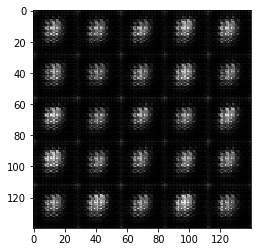

Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 3.0327
Epoch 1/2... Discriminator Loss: 0.4541... Generator Loss: 2.5832
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 3.8064
Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 3.7158
Epoch 1/2... Discriminator Loss: 0.3807... Generator Loss: 3.7225
Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 3.7678
Epoch 1/2... Discriminator Loss: 0.4247... Generator Loss: 2.9340
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 3.4502
Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 3.9261
Epoch 1/2... Discriminator Loss: 0.3671... Generator Loss: 4.4928


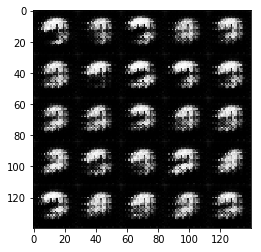

Epoch 1/2... Discriminator Loss: 0.5501... Generator Loss: 5.6672
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 4.6130
Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 2.2655
Epoch 1/2... Discriminator Loss: 0.4577... Generator Loss: 2.9728
Epoch 1/2... Discriminator Loss: 0.4718... Generator Loss: 3.0698
Epoch 1/2... Discriminator Loss: 0.5506... Generator Loss: 2.1243
Epoch 1/2... Discriminator Loss: 0.5017... Generator Loss: 2.6333
Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 2.6040
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.9647
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 2.0756


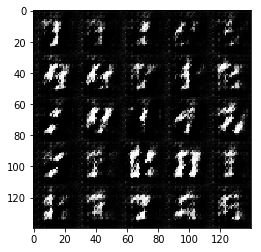

Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 2.3207
Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 1.6707
Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 2.0366
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 2.5800
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 1.6285
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 3.0474
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.4905


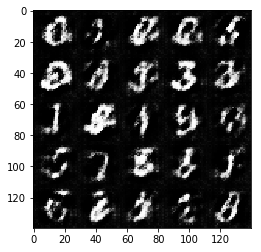

Epoch 1/2... Discriminator Loss: 0.8108... Generator Loss: 1.4520
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 2.6049
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 1.0018
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 2.2111
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 2.8133
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 1.6318
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.9286
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 2.2933
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 0.9369


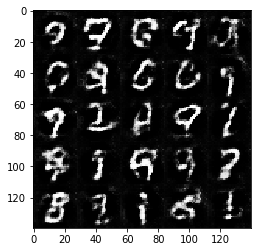

Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.7316
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.8941
Epoch 2/2... Discriminator Loss: 0.9143... Generator Loss: 1.3725
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 1.9074
Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.4377
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.5124
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.8269
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 2.0271
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.1341


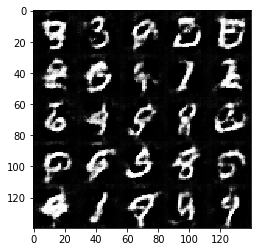

Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.5199
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.2253
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 2.2664
Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 2.1023
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 1.8491
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.5898
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.5938
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.1946


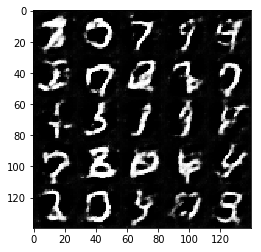

Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.3318
Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 2.2829
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.4657
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.5221
Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 1.8826
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 1.9440
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.2838
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.4970
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.4541


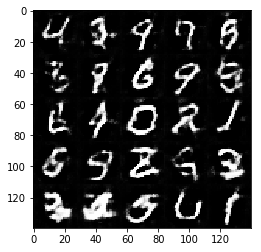

Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.1184
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.1837
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.5478
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.1028
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 1.6450
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 2.1082
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 1.2448
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.1758


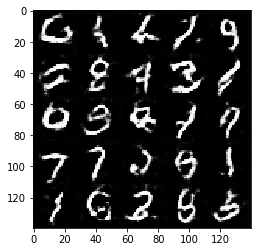

Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 1.6308
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.1413
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.9119


In [60]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 12.2238
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 3.2168
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.8054
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 14.8220
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 9.2591
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 10.4747
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 2.9002
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 2.0700


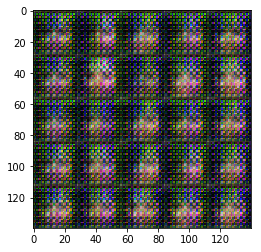

Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 2.1101
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.6196
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.4746
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 2.2649


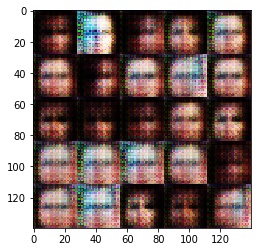

Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 2.8878
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 2.6785
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.7706
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.8217
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0042


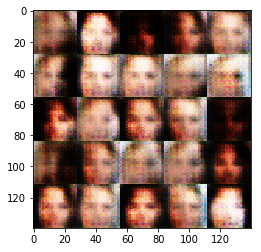

Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.9903
Epoch 1/1... Discriminator Loss: 2.0292... Generator Loss: 4.3989
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 1.8178... Generator Loss: 0.3194
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 2.0488
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 2.0921
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.1696


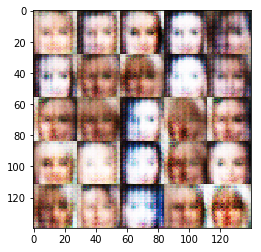

Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.4110
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.3914
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7331


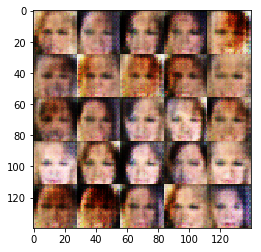

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.7021
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.6117
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.9800


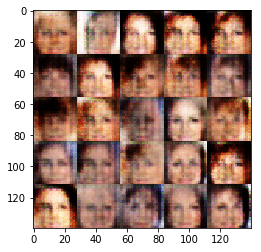

Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.9992... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.1752


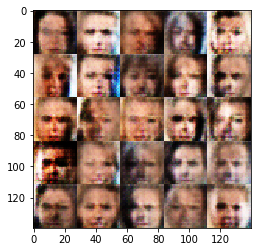

Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.6212
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.8077
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.2190


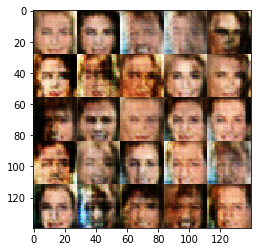

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 2.0490
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.4848
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 2.2148
Epoch 1/1... Discriminator Loss: 2.0394... Generator Loss: 3.0608
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.0285


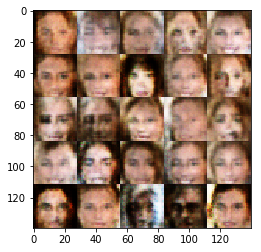

Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9389


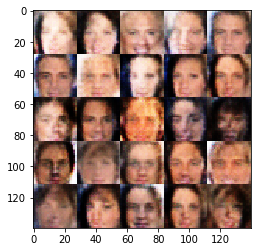

Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.8669
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0208


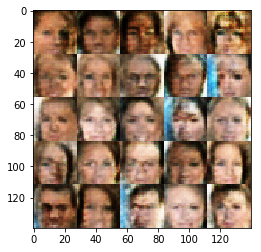

Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 2.0153
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 1.5474
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 1.6768
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.4941


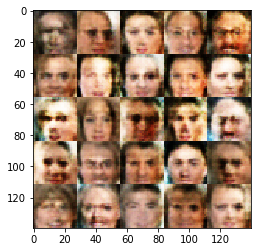

Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7453


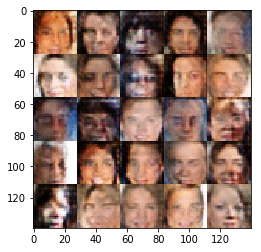

Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.4878


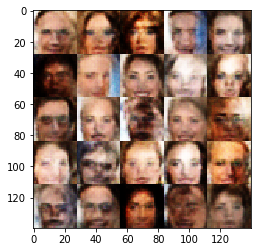

Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.6746
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 2.2476... Generator Loss: 3.4305
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.7682


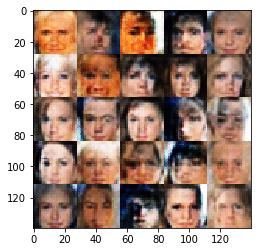

Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.9957
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.7075
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.3047


In [58]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)